# **Displacement and Housing Burden in Los Angeles County**
## *By Bryzen Morales, Elizabeth Shin, Gina Ranieri, and Leo Blain*

The recent Los Angeles wildfires have displaced thousands of people, creating a sudden surge in demand for long-term rental housing–just as supply has drastically shrunk. According to [Strategic Actions for a Just Economy](https://inthesetimes.com/article/price-gouging-wildfires-los-angeles-landlords), many landlords have taken advantage of this crisis by illegally inflating rental prices across the city. While some displaced residents—such as wealthy homeowners from Pacific Palisades—may be able to absorb these costs, many others cannot.

**Rental price gouging will disproportionately harm economically and demographically vulnerable populations, further deepening inequalities across Los Angeles County. In this project, we seek to identify the communities or neighboroods who are most vulnerable to rental price gouging. This vulnerability, we think, is a contributor to both housing burden and displacement across the Los Angeles County.**

Disclaimer: most of the codes included here came from the class' general GitHub repo. Some modifications have been included and I have linked them as a reference.

# 1 | Analytical Framework

We have been using the housing burden index from the [California Environmental Justice Alliance (CEJA) CalEnviroScreen tool](https://oehha.ca.gov/calenviroscreen/indicator/housing-burden) to understand neighborhood "vulnerability" to wildfires at the Census tract level (which is our proxy for our neighborhoods). However, this index is out-dated and measures housing burden against the whole California. Additionally, we may have to incorporate other comprehensive variables (demographic and other characteristics) to make a new, updated, contemporary, and comprehensive index. 

To advance our project into, ultimately, unifying a vulnerability, we will use four key neighborhood attributes from the 2018-2022 5-year American Community Survey (ACS) estimates: rate of people of color, rate of old buildings, rate of cost burdened households, and rate of age 65+ within a neighborhood. These attributes comes from the adaptive capacity variables, elaborated in the socio-ecological model [Davies et al., 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0205825) offers. For the purpose of this assignment, we will use an unsupervised machine learning technique called Principal Component Analysis to create this index. This technique has been used by key major organizations like [USAID](https://dhsprogram.com/topics/wealth-index/Wealth-Index-Construction.cfm) to create index. A summary can be found [here](https://mr-hn.github.io/pcaIndex/). We also end with a spatial autocorrelation analysis to see if this new index tends to cluster spatially. 

Note: We only use four variables for this index creation. We hope to include more later on, by the final.

# 2 | Part 1: Data Extraction and Preparation

Though we have Social Explorer and the US Census website as a tool, we are going to try to use an API to ease our process. The documentation source for these codes comes from [PyGIS]("https://pygis.io/docs/d_access_census.html") and this formal [census documentation]("https://pypi.org/project/census/'). We will call every variable by referencing this [data dictionary documentation]("https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-79594641") of the ACS 2015-2019 estimates. Now, let's import the modules
and call all of our variables.

In [1]:
## importing necessary modules ##

# for graphing
import matplotlib.pyplot as plt

# for (sophisticated) graphing
import plotly.express as px

# for more graphing tools
import seaborn as sns

# for data wrangling
import pandas as pd

# for more data wrangling
import numpy as np

# for handling spatial data
import geopandas as gpd

# for using API from Census

! pip install Census
! pip install us

from census import Census
from us import states

# for basemaps

import contextily as ctx

# for spatial statistics

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# for reclassification

import mapclassify

# for PCA

from sklearn.decomposition import PCA

# for spatial weights

from libpysal import weights

In [2]:
# calling Census using API key (obtained by: Bryzen)

c = Census("ef95485bd9d6c9a56f245ed4f2cc2ad96fe5eb1f")

In [3]:
# importing ACS data 

ca_census = c.acs5.state_county_tract(
    fields = ('NAME', 
              'B01001_001E', # total population
              'B02001_002E', # white alone 
              'B02001_003E', # black alone
              'B02001_004E', # american indian alone
              'B02001_005E', # asian alone
              'B03002_012E', # hispanic or latino
              'B03002_002E', # non-hispanic or latino,
              # age groups
              'B01001_020E',
              'B01001_021E',
              'B01001_022E',
              'B01001_023E',
              'B01001_024E',
              'B01001_025E',
              'B01001_044E',
              'B01001_045E',
              'B01001_046E',
              'B01001_047E',
              'B01001_048E',
              'B01001_049E',
              
              'B03002_003E', # non-hispanic white
              'B25034_001E', # total housing units
              'B25034_008E', # built 1960-1969
              'B25034_009E', # built 1950-1959
              'B25034_010E', # built 1940-1949
              'B25034_011E', # built 1939 or earlier
              'B25004_001E', # vacant housing units
              'B25004_002E', # for rent housing units
              'B25004_004E', # for sale housing units
              'B25004_008E', # other vacant housing units
              'B25058_001E', # median contract rent
              'B25105_001E', # median monthly housing costs
              'B25106_024E', # renter-occupied housing units
              'B25106_028E', # for income bracket, 20,000, allocates 30% or more housing costs
              'B25106_032E', # for income bracket, 20k to 34k, allocates 30% or more housing costs
              'B25106_036E', # for income bracket, 35k to 49k, allocates 30% or more housing costs
              'B25106_040E'  # for income bracket, 50k to 74k, allocates 30% or more housing costs
              ),
    state_fips = states.CA.fips,
    county_fips = "*",
    tract = "*",
    year = 2022)

In [4]:
# converting into a pandas data frame

ca_census_df = pd.DataFrame(ca_census)

In [5]:
# inspecting the data frame's properties

ca_census_df.head(1)

,NAME,B01001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B03002_012E,B03002_002E,B01001_020E,B01001_021E,...,B25058_001E,B25105_001E,B25106_024E,B25106_028E,B25106_032E,B25106_036E,B25106_040E,state,county,tract
0,Census Tract 4001; Alameda County; California,3269.0,2385.0,171.0,0.0,477.0,167.0,3102.0,19.0,76.0,...,3501.0,4001.0,127.0,0.0,0.0,8.0,0.0,06,001,400100


In [6]:
# creating a string to create a FIPS column 

ca_census_df["GEOID"] = ca_census_df["state"] + ca_census_df["county"] + ca_census_df["tract"]

ca_census_df.tail(1)

,NAME,B01001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B03002_012E,B03002_002E,B01001_020E,B01001_021E,...,B25105_001E,B25106_024E,B25106_028E,B25106_032E,B25106_036E,B25106_040E,state,county,tract,GEOID
9128,Census Tract 411.02; Yuba County; California,1010.0,961.0,0.0,0.0,9.0,32.0,978.0,28.0,25.0,...,1125.0,51.0,0.0,0.0,0.0,27.0,06,115,041102,06115041102


# 3 | Part 2: More Data Cleaning, Subsetting and Merging

**Our variables are very confusing!** There is so many of them, let's rename every variable! Also, let us subset the data to only include the county of LA and merge this with the CalEnviroScreen dataset.

In [7]:
# subsetting the data to only include the state to be in LA

tracts_v2 = ca_census_df[ca_census_df['county']=='037']

In [8]:
# importing CalEnviroScreen 4.0 Housing Burden data

index = gpd.read_file("/home/jovyan/UP221-bryzen/data/index_shp/index.shp")

In [9]:
# merge datasets together

la = pd.merge(index, 
              tracts_v2,
              left_on = 'Geo_FIPS',
              right_on = 'GEOID')

In [10]:
# converting to geodata frame and specifying the "geometry" column as the "index"

la_gpd_df = gpd.GeoDataFrame(data=la, geometry=la['geometry']).to_crs(4326)

In [11]:
# renaming the column names

la_gpd_df = la_gpd_df.rename(
    columns={
              'B01001_001E' : 'total_pop',
              'B02001_002E' : 'white_pop', 
              'B02001_003E' : 'black_pop',
              'B02001_004E' : 'american_indian_pop',
              'B02001_005E' : 'asian_pop',
              'B03002_012E' : 'hispanic',
              'B03002_002E' : 'non-hispanic',
              'B01001_020E' : '65-66-male',
              'B01001_021E' : '67-69-male',
              'B01001_022E' : '70-74-male',
              'B01001_023E' : '75-79-male',
              'B01001_024E' : '80-84-male',
              'B01001_025E' : '85+-male',
              'B01001_044E' : '65-66-female',
              'B01001_045E' : '67-69-female',
              'B01001_046E' : '70-74-female',
              'B01001_047E' : '75-79-female',
              'B01001_048E' : '80-84-female',
              'B01001_049E' : '85+-female',
              'B03002_003E' : 'non_hispanic_white',
              'B25034_001E' : 'total_housing',
              'B25034_008E' : 'housing_1960_1969',
              'B25034_009E' : 'housing_1950_1959',
              'B25034_010E' : 'housing_1940_1949',
              'B25034_011E' : 'housing_1939_earlier',
              'B25004_001E' : 'vacant_housing_units',
              'B25004_002E' : 'rent_housing_units',
              'B25004_004E' : 'sale_housing_units',
              'B25004_008E' : 'other_vacant_housing units',
              'B25058_001E' : 'median_contract_rent',
              'B25105_001E' : 'median_monthly_housing_costs',
              'B25106_024E' : 'renter_occupied_housing_units',
              'B25106_028E' : 'less_than_20k',
              'B25106_032E' : '20k_to_34k',
              'B25106_036E' : '35k_to_49k',
              'B25106_040E' : '50k_to_74k'
    })

In [12]:
# Whew... too many variables!! Let's make sure
# all the variables are included though.

la_gpd_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Geo_FIPS                       2018 non-null   object  
 1   Census Tra                     2018 non-null   object  
 2   Median Con                     1982 non-null   float64 
 3   Median Mon                     1993 non-null   float64 
 4   Total Rent                     2018 non-null   int64   
 5   less than                      2018 non-null   int64   
 6   20,000 to                      2018 non-null   int64   
 7   35,000 To                      2018 non-null   int64   
 8   50,000 To                      2018 non-null   int64   
 9   less tha_1                     1997 non-null   float64 
 10  20,000 t_1                     1997 non-null   float64 
 11  35,000 T_1                     1997 non-null   float64 
 12  50,000 T_1                

# 4 | Part 1: New Vulnerability Measure? Principal Component Analysis (PCA) 

PCA, in its simplest words, combines information from highly-correlated variables to "summarize" it into one (or more) "principal component" which can be referred to as an "index." We can calculate many principal components or "index", but what do we want? a principal component with **high variance** . Think about it this way: we have a summary, which is an "index," but what we want is a summary packed with dense information, "high variance." The code for this can be found from this [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform).

Now, this is perfect for our objective. We want a unified index that uses information from a most recent dataset and one larger geography, Los Angeles County, to create a comparable index. 

In [13]:
## calculating relevant statistics

# calculating percent of people of color
la_gpd_df['rate_poc'] = ((la_gpd_df['hispanic'] + la_gpd_df['non-hispanic'] - la_gpd_df['non_hispanic_white']) / (la_gpd_df['hispanic'] + la_gpd_df['non-hispanic'])) 

# calculating percent of white
la_gpd_df['rate_white'] = la_gpd_df['non_hispanic_white']/ (la_gpd_df['hispanic'] + la_gpd_df['non-hispanic']) 

# calculating relative frequency of old housing units
la_gpd_df['rate_old_bldg'] = (la_gpd_df['housing_1960_1969'] + la_gpd_df['housing_1950_1959'] +  la_gpd_df['housing_1940_1949'] +  la_gpd_df['housing_1939_earlier']) / la_gpd_df['total_housing']

# calculating relative frequency of 65+ age
la_gpd_df['rate_65+'] = (la_gpd_df['65-66-male'] + la_gpd_df['67-69-male'] + la_gpd_df['70-74-male'] + la_gpd_df['75-79-male'] + la_gpd_df['80-84-male'] + la_gpd_df['80-84-male'] +  la_gpd_df['85+-male'] + la_gpd_df['65-66-female'] + la_gpd_df['67-69-female'] + la_gpd_df['70-74-female'] + la_gpd_df['75-79-female'] + la_gpd_df['80-84-female'] + la_gpd_df['80-84-female'] +  la_gpd_df['85+-female'])/ (la_gpd_df['total_pop']) 

# calculating proportion of "housing burdened"
la_gpd_df["less_than_20k_prop"] = la_gpd_df["less_than_20k"] / la_gpd_df["renter_occupied_housing_units"]

In [14]:
# dropping missing observations of the data frame

la_gpd_df = la_gpd_df.dropna()

In [15]:
# specifying we only want one component (this automatically
# spews out the component with the highest variance)

pca = PCA(n_components=1)

# performing the PCA and adding it as a new column

la_gpd_df["housing_burden_new"] = pca.fit_transform(la_gpd_df[["rate_65+", "less_than_20k_prop", "rate_poc", "rate_old_bldg"]])

# this is the variance that the current component or "index" 

pca.explained_variance_ratio_[0]

np.float64(0.5235379177439617)

We see that only using four variables, we can create a unified index that already explains "vulnerability" 50% of the time! While we can improve this, for our analysis, this may be enough this time. Now, let's compare our plots together.

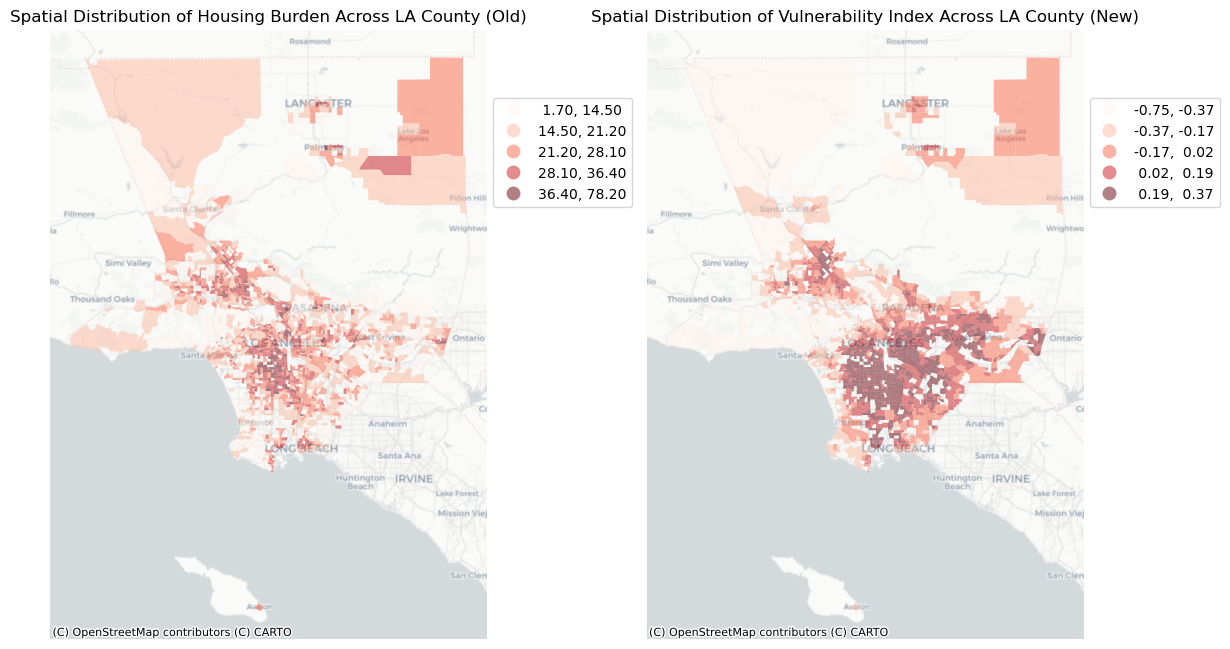

In [22]:
## creating the maps
fig, ax = plt.subplots(1, 2, figsize = (12,12))

# creating a map for the OLD housing burden

la_gpd_df.plot(
    ax = ax[0],
    column = 'Housing Bu',
    scheme = "naturalbreaks",
    k = 5, 
    alpha = 0.5,
    legend = True,
    cmap = 'Reds',
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)}
)
ax[0].set_title("Spatial Distribution of Housing Burden Across LA County (Old)")

# setting the axis off

ax[0].axis('off')

ctx.add_basemap(ax=ax[0],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

# creating a map for the NEW index

la_gpd_df.plot(
    ax = ax[1],
    column = 'housing_burden_new',
    alpha = 0.5,
    cmap = 'Reds',
    scheme = "naturalbreaks",
    k = 5, 
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend = True,
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)
    }
)
ax[1].set_title("Spatial Distribution of Vulnerability Index Across LA County (New)")
ax[1].axis('off')
ctx.add_basemap(ax=ax[1],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

plt.tight_layout()
plt.show()

<div class="alert alert-danger">
    
<h2>Woah!</h2>

The old and new index are very different!!! First, there are "more" vulnerable neighborhoods the new index captures. Second, there are index that are "negative." Therefore, we put caveats for our new index. The scaling that we used for the new index are in proportion and relative frequency, which is different from the old "housing burden" index (i.e., it uses absolute numbers). Again, the nature of the data and the type of variables that we included in the new index is very different from the old one! Third, the "negative" index should not be worrisome. The mathematics behind PCA can, actually, lead to negative integers! With that being said, this index is a methodological choice and is based on our discretion. This should not be interpreted as the absolute "vulnerability" measure, but moreso as a start.  

</div>

# 4 | Part 2: Is Vulnerability A Spatial Issue? Spatial Autocorrelation of Vulnerability Index

We have seen that the new index has clustering around the Downtown and the middle of Los Angeles. However, as Giamarino (2025) asserts, we need a geostatistical tool to confirm if these values tend to cluster with one another. We, then, use the Global Moran's I statistic to "quantify the degree to which similar geographies are clustered." 

First step: defining a "spatial weight." Spatial weights, at the simplest terms, is the degree through which our Census tracts or neighborhood proxies are related. Do these neighborhoods touch each other boundaries? Are these neighborhoods near other "neighborhoods"? For this analysis, we use the k-nearest neighbors" spatial weights from Giamarino (2025).

In [19]:
# calculate spatial weight

weights =  lps.weights.KNN.from_dataframe(la_gpd_df,
                                          k=8)

# row-standardizing

weights.transform = 'r'

Now, let's use the spatial weights to calculate the spatial lag, which uses these weights to inform how much of eight other nearest Census tracts influences the index of the other.

In [21]:
# calculating spatial lag

la_gpd_df['index_lag'] = lps.weights.lag_spatial(weights,
                                                 la_gpd_df['housing_burden_new']
                                                )

la_gpd_df.head(2)

,Geo_FIPS,Census Tra,Median Con,Median Mon,Total Rent,less than,"20,000 to","35,000 To","50,000 To",less tha_1,...,county,tract,GEOID_y,rate_poc,rate_white,rate_old_bldg,rate_65+,less_than_20k_prop,housing_burden_new,index_lag
0,06037101110,Census Tract 1011.10,1468.0,1853.0,732,147,103,104,53,0.200820,...,037,101110,06037101110,0.442950,0.557050,0.774818,0.228201,0.181435,-0.202841,-0.263470
1,06037101122,Census Tract 1011.22,2067.0,2273.0,240,22,27,34,39,0.091667,...,037,101122,06037101122,0.307877,0.692123,0.627891,0.247358,0.154070,-0.391817,-0.239848


Okay. Now, let's compare this new index with one another where the other map is just its spatial lag.

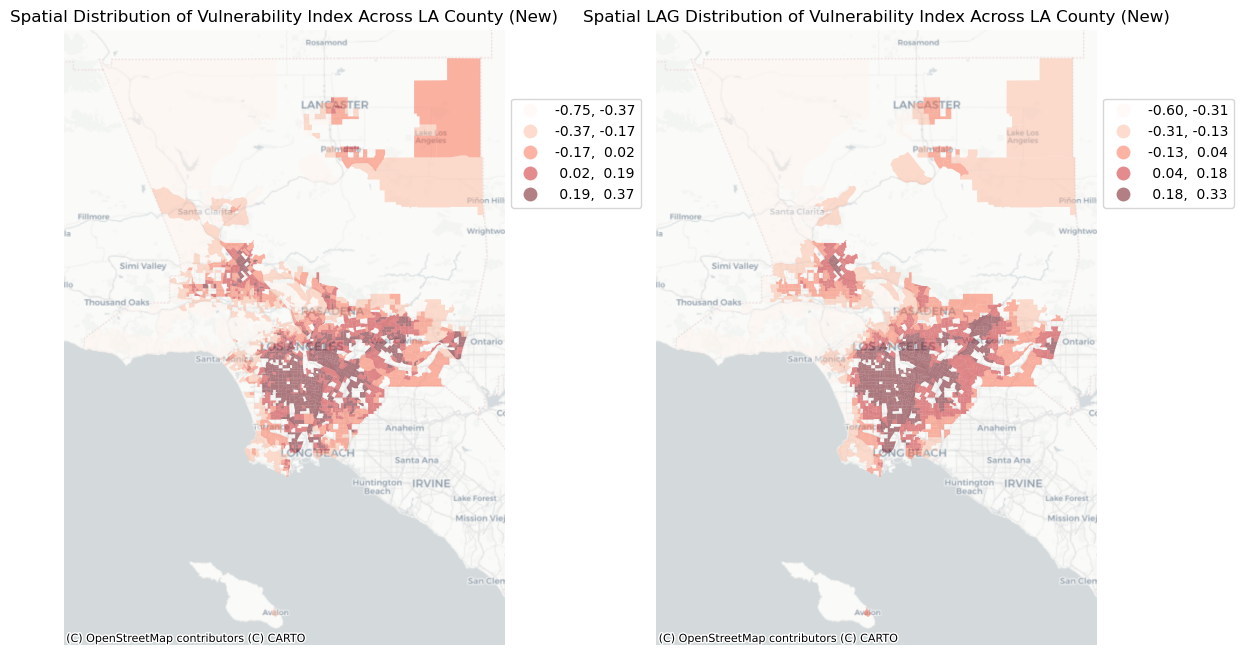

In [24]:
## creating the maps
fig, ax = plt.subplots(1, 2, figsize = (12,12))

# creating a map for the OLD housing burden

la_gpd_df.plot(
    ax = ax[0],
    column = 'housing_burden_new',
    scheme = "naturalbreaks",
    k = 5, 
    alpha = 0.5,
    legend = True,
    cmap = 'Reds',
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)}
)
ax[0].set_title("Spatial Distribution of Vulnerability Index Across LA County (New)")

# setting the axis off

ax[0].axis('off')

ctx.add_basemap(ax=ax[0],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

# creating a map for the NEW index

la_gpd_df.plot(
    ax = ax[1],
    column = 'index_lag',
    alpha = 0.5,
    cmap = 'Reds',
    scheme = "naturalbreaks",
    k = 5, 
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend = True,
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)
    }
)
ax[1].set_title("Spatial LAG Distribution of Vulnerability Index Across LA County (New)")
ax[1].axis('off')
ctx.add_basemap(ax=ax[1],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

plt.tight_layout()
plt.show()

Now, one observation we have is visually, there does not seem to be obvious changes. But, the legend tells us that using a natural breaks category, the range of the spatial lag of the new vulnerability index changed. It became more precise!

It may be helpful, however, to calculate the Moran's I value, which indicates global spatial autocorrelation, the common spatial relationship within the whole LA County. A positive value reveals that high vulnerability index values tend to be close with high vulnerability index values (or low values tend to be close with low values). A negative value is the opposite.

In [32]:
y = la_gpd_df.index_lag

# global moran's I calculation
moran = Moran(y, weights)

print('morans I spatial autocorrelation value:', moran.I)
print('morans p-value:', moran.p_sim)

morans I spatial autocorrelation value: 0.9484868210929663
morans p-value: 0.001


We see very high positive spatial autocorrelation! Great! This value complements the map we visualized!!! We also see a p-value lower than 0.05 or 0.01. 

This means that this spatial relationship is not just random, there seems to be a spatial pattern of vulnerability.

At this point, it may be helpful to use the Local Indicators of Spatial Association (LISA) where we actually see where these clustering of vulnerabilities are "locally". Let's set the p-value to 0.05, to show statistically significant clusters.

In [34]:
# local moran's calculation

lisa = esda.moran.Moran_Local(y, weights)

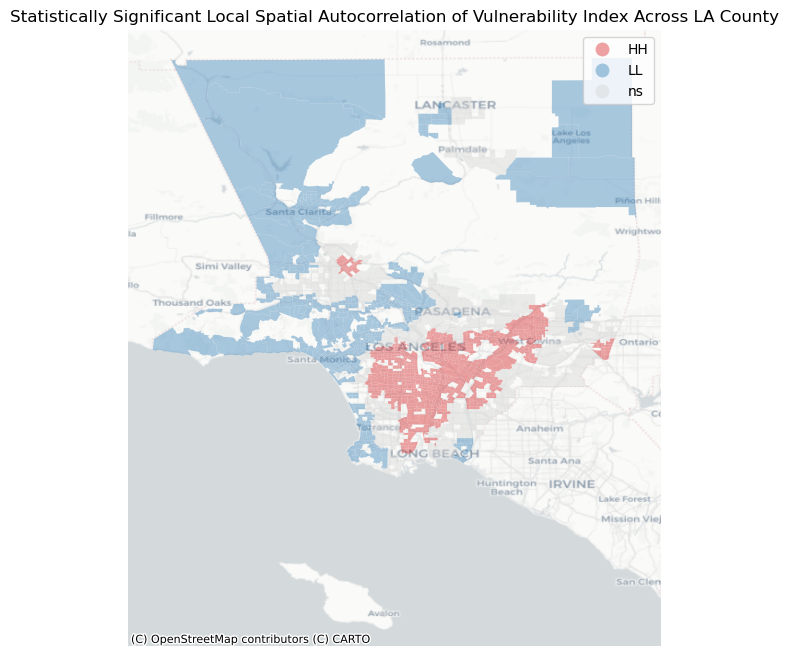

In [53]:
# creating maps

# create the 1x2 subplots
fig, ax = plt.subplots(figsize = (8,8))

# regular count map on the left
lisa_cluster(lisa, 
             la_gpd_df, 
             p=0.05, 
             ax=ax,
             alpha = 0.4
            )

ax.axis("off")
ax.set_title("Statistically Significant Local Spatial Autocorrelation of Vulnerability Index Across LA County")
ctx.add_basemap(ax=ax,
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)


plt.show()

Using Moran's Global Spatial Autocorrelation and LISA, we confirm that vulnerability seems to cluster around the Downtown, LA area. We also find that the low, low (i.e., low index values tend to be closer with low index values) is more pronounced around the West side LA.